### EDA de los datasets limpios y elección de las variables para el modelo de recomendación

*Importaciones*

In [3]:
pip install textblob


  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/626.3 kB 131.3 kB/s eta 0:00:05
   - ------------------------------------- 20.5/626.3 kB 131.3 kB/s eta 0:00:05
   - ------------------------------------- 30.7/626.3 kB 146.3 kB/s eta 0:00:05
   -- ------------------------------------ 41.0/626.3 kB 151.3 kB/s eta 0:00:04
   --- ----------------------------------- 61.4/626.3 kB 204.8 kB/s eta 0:00:03
   ----- --------------------------------- 92.2/626.3 kB 275.8 kB/s eta 0:00:02
   ------ ---------------

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import herramientas
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

### EDA del dataset user_reviews
*En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto user_reviews que ya pasó por el proceso de ETL.*

Lectura del conjunto de datos
Se leen los datos de .parquet y se guarda en un dataframe.

In [44]:
#df_ = pd.read_parquet(r'C:\Users\Sofi\Desktop\Henry\LABS\Proyecto_STEAM\Data_Clean\user_reviews_clean.parquet')
#df_reviews

In [5]:
df_reviews = pd.read_parquet(r'C:\Users\Owner\Desktop\LABS\Proyecto_STEAM\datos_STEAM\parquet\reviews_clean_sentiment.parquet')
df_reviews

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted November 5, 2011.",1250,True,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted July 15, 2011.",22200,True,2
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,2
3,js41637,http://steamcommunity.com/id/js41637,"Posted June 24, 2014.",251610,True,2
4,js41637,http://steamcommunity.com/id/js41637,"Posted September 8, 2013.",227300,True,2
...,...,...,...,...,...,...
59328,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 10.,70,True,2
59329,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 8.,362890,True,2
59330,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,Posted July 3.,273110,True,2
59331,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,Posted July 20.,730,True,2


*Se revisan los tipos de datos y cantidad de nulos si hay.*

In [6]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_reviews.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
herramientas.tipo_datos(df_reviews)

La cantidad de registros que hay son: 59333


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.00,0.00,0
1,user_url,[<class 'str'>],100.00,0.00,0
2,posted,"[<class 'str'>, <class 'NoneType'>]",99.95,0.05,28
3,item_id,"[<class 'str'>, <class 'NoneType'>]",99.95,0.05,28
4,recommend,"[<class 'bool'>, <class 'NoneType'>]",99.95,0.05,28
5,sentiment_analysis,[<class 'int'>],100.00,0.00,0


*Se tienen 59333 registros de opiniones de los usuarios respecto a los juegos que consumen. Si bien no hay nulos, hay que recordar que en el ETL se observaron datos faltantes en la columna 'reviews_date' donde se rellenó con 'Formato inválido'.*

Columnas 'sentiment_analysis' y 'reviews_recommend'
*Se exploran las columnas 'sentiment_analysis' y 'reviews_recommend'.*

In [7]:
herramientas.resumen_porcentajes(df_reviews, 'sentiment_analysis')

,Cantidad,Porcentaje
sentiment_analysis,,
2,50056,84.36
0,8189,13.80
1,1088,1.83


In [8]:
herramientas.resumen_porcentajes(df_reviews, 'recommend')

,Cantidad,Porcentaje
recommend,,
True,52473,88.44
False,6832,11.51


*De la columna 'sentiment_analysis' el 84.36% de los reviews reflejan sentimientos positivos, el 13.80% reflejan sentimientos negativos hacia el juego y el 1.83% son neutros. Mientras que el 88.44% de los reviews recomiendan los juegos que consumen.*

In [9]:
# Cantidad de usuarios que dieron su opinion
print(f"Cantidad de usuarios únicos que opinaron: {len(df_reviews['user_id'].unique())}")

Cantidad de usuarios únicos que opinaron: 25485


###### *Un total de 25143 usurarios dieron su opinión sobre el juego que consumen. Por lo tanto, un usuario hizo mas de un comentario.*

*Se analiza la distribución de comentarios por mes y año*

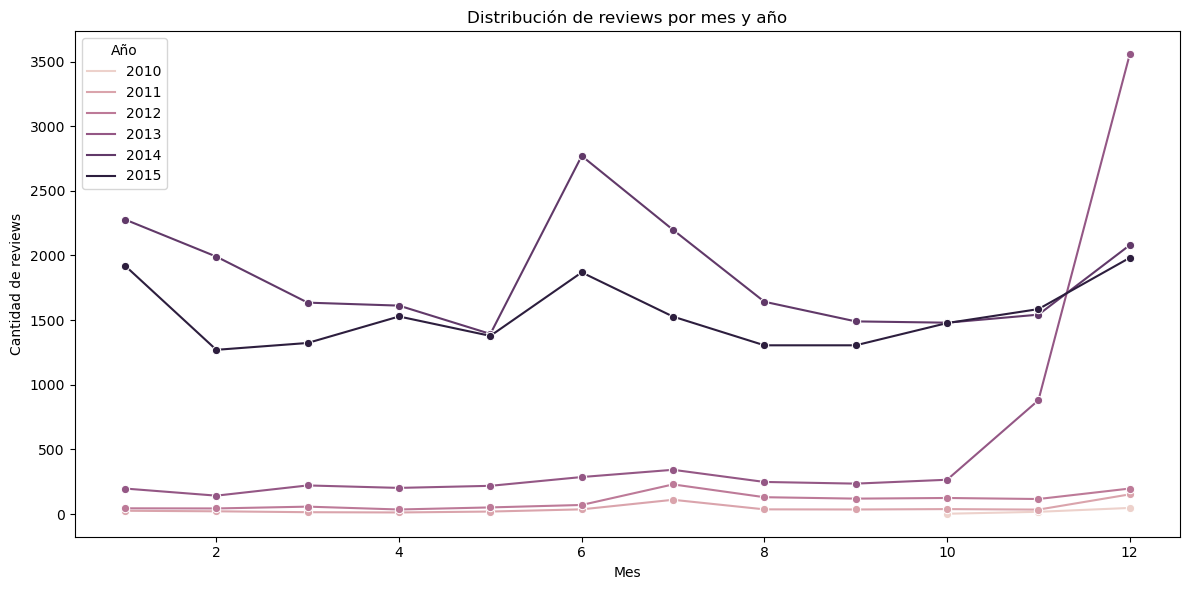

In [10]:
# Extraer "" y convertir las fechas al formato deseado
df_reviews["posted"] = df_reviews["posted"].str.extract(r'Posted (.+?)\.')
df_reviews["posted"] = pd.to_datetime(df_reviews["posted"], format="%B %d, %Y", errors='coerce')

# Eliminar filas con fechas que no se pudieron convertir
df_reviews = df_reviews.dropna(subset=['posted'])

# Agregar columnas para el mes y el año
df_reviews['month'] = df_reviews['posted'].dt.month
df_reviews['year'] = df_reviews['posted'].dt.year

# Calcular la cantidad de reviews por mes y año
df_counts = df_reviews.groupby(['year', 'month']).size().reset_index(name='Cantidad de reviews')

# Graficar la distribución de reviews por mes y año
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_counts, x="month", y="Cantidad de reviews", hue="year", marker='o')
plt.xlabel('Mes')
plt.ylabel('Cantidad de reviews')
plt.title('Distribución de reviews por mes y año')
plt.legend(title='Año')
plt.tight_layout()
plt.show()

##### EDA del dataset steam_games

###### En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto steam_games que ya pasó por el proceso de ETL.

*Lectura del conjunto de datos*

In [45]:
df_games = pd.read_parquet(r'C:\Users\Owner\Desktop\LABS\Proyecto_STEAM\datos_STEAM\parquet\games_clean3.parquet')
df_games

,id,app_name,developer,genres,price,release_date
0,761140,Lost Summoner Kitty,Kotoshiro,Action,4.99,2018
1,643980,Ironbound,Secret Level SRL,Indie,0.00,2018
2,670290,Real Pool 3D - Poolians,Poolians.com,Casual,0.00,2017
3,767400,弹炸人2222,彼岸领域,Action,0.99,2017
4,773570,Log Challenge,None,Action,2.99,None
...,...,...,...,...,...,...
32130,773640,Colony On Mars,"Nikita ""Ghost_RUS""",Casual,1.99,2018
32131,733530,LOGistICAL: South Africa,Sacada,Casual,4.99,2018
32132,610660,Russian Roads,Laush Dmitriy Sergeevich,Indie,1.99,2018
32133,658870,EXIT 2 - Directions,"xropi,stev3ns",Casual,4.99,2017


*Se revisan los tipos de datos y cantidad de nulos si hay.*

In [46]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_games.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
herramientas.tipo_datos(df_games)

La cantidad de registros que hay son: 32135


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,id,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
1,app_name,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
2,developer,"[<class 'str'>, <class 'NoneType'>]",89.94,10.06,3234
3,genres,"[<class 'str'>, <class 'NoneType'>]",99.57,0.43,139
4,price,[<class 'float'>],96.35,3.65,1173
5,release_date,"[<class 'str'>, <class 'NoneType'>]",93.25,6.75,2168


Columnas 'id', 'app_name' y 'title'

*Estas columnas hacen referencia al identificador único del juego y los nombres de la aplicación y del título del juego. Estos últimos no tienen mayor información que analizar en este momento. Con el 'id' se puede calcular la cantidad de juegos.*

In [47]:
total_juegos = len(df_games['id'].unique())
print(f"El total de juegos que hay registrados son: {total_juegos}")

El total de juegos que hay registrados son: 32133


Columna 'genres'

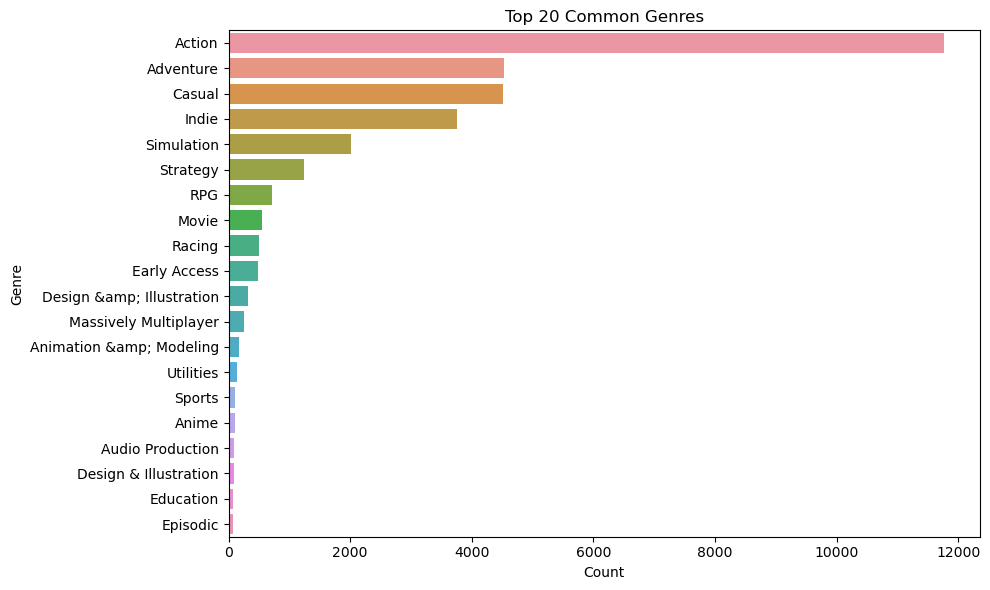

In [48]:
# Calcular la frecuencia de cada género
genre_counts = df_games['genres'].value_counts()

# Seleccionar los 20 géneros más comunes
top_genres = genre_counts.head(20)

# Crear un DataFrame con los géneros más comunes y sus frecuencias
top_genres_df = pd.DataFrame({'Genre': top_genres.index, 'Count': top_genres.values})

# Graficar los géneros más comunes
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres_df, x='Count', y='Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 20 Common Genres')
plt.tight_layout()
plt.show()

In [49]:
Genres_porcenjae = herramientas.resumen_porcentajes(df_games, 'genres')
Genres_porcenjae.head(20)

,Cantidad,Porcentaje
genres,,
Action,11770,36.63
Adventure,4530,14.10
Casual,4521,14.07
Indie,3763,11.71
Simulation,2019,6.28
Strategy,1245,3.87
RPG,718,2.23
Movie,552,1.72
Racing,504,1.57


Columna 'release_date'

In [50]:
herramientas.resumen_porcentajes(df_games, 'release_date')[:10]

,Cantidad,Porcentaje
release_date,,
2017,9595,29.86
2016,6943,21.61
2015,4952,15.41
2014,2844,8.85
2013,1552,4.83
2012,1193,3.71
2011,590,1.84
2010,442,1.38
2009,341,1.06


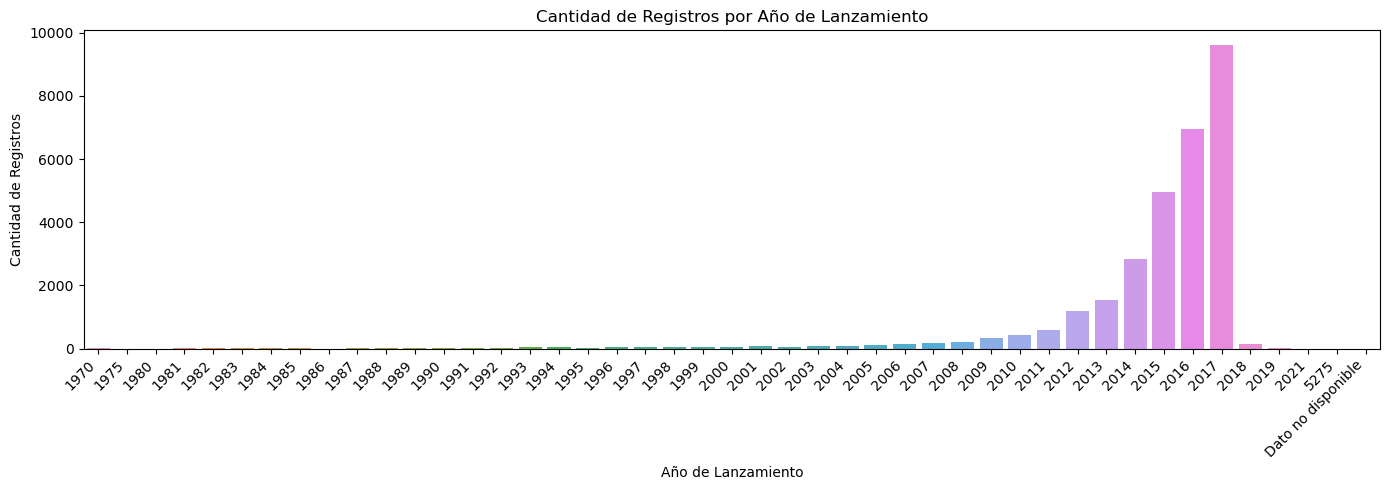

In [51]:
# Cuenta la frecuencia de cada año
conteo_anios = df_games['release_date'].value_counts()

# Ordena los valores para que 'Datos no disponibles' queden al principio o al final
conteo_anios = conteo_anios.reindex(['Dato no disponible'] + list(conteo_anios.index))
# Ordena los valores por año
conteo_anios = conteo_anios.sort_index()

# Crear la gráfica de barras
plt.figure(figsize=(14, 5))
sns.barplot(x=conteo_anios.index, y=conteo_anios.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('Cantidad de Registros') ; plt.title('Cantidad de Registros por Año de Lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Columnas 'publisher' y 'developer'

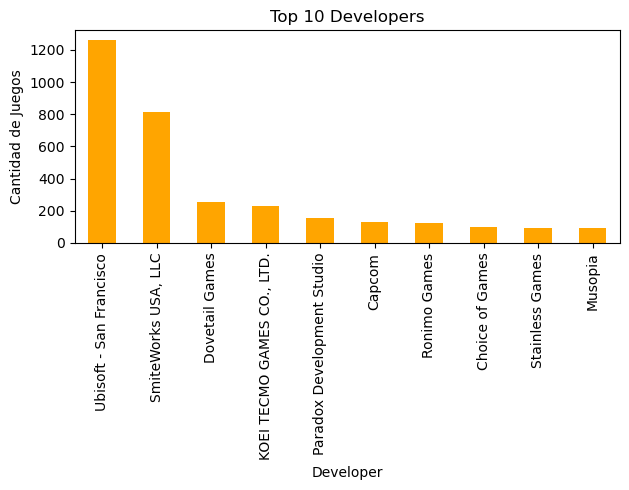

In [19]:
# Contar la cantidad de juegos por developer
conteo_developer = df_games['developer'].value_counts()

# Crear una figura con dos subplots uno al lado del otro
plt.figure(figsize=(12, 5))

# Segundo subplot para los developers
plt.subplot(1, 2, 2)
conteo_developer[:10].plot(kind='bar', color='orange')
plt.xlabel('Developer') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Developers')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

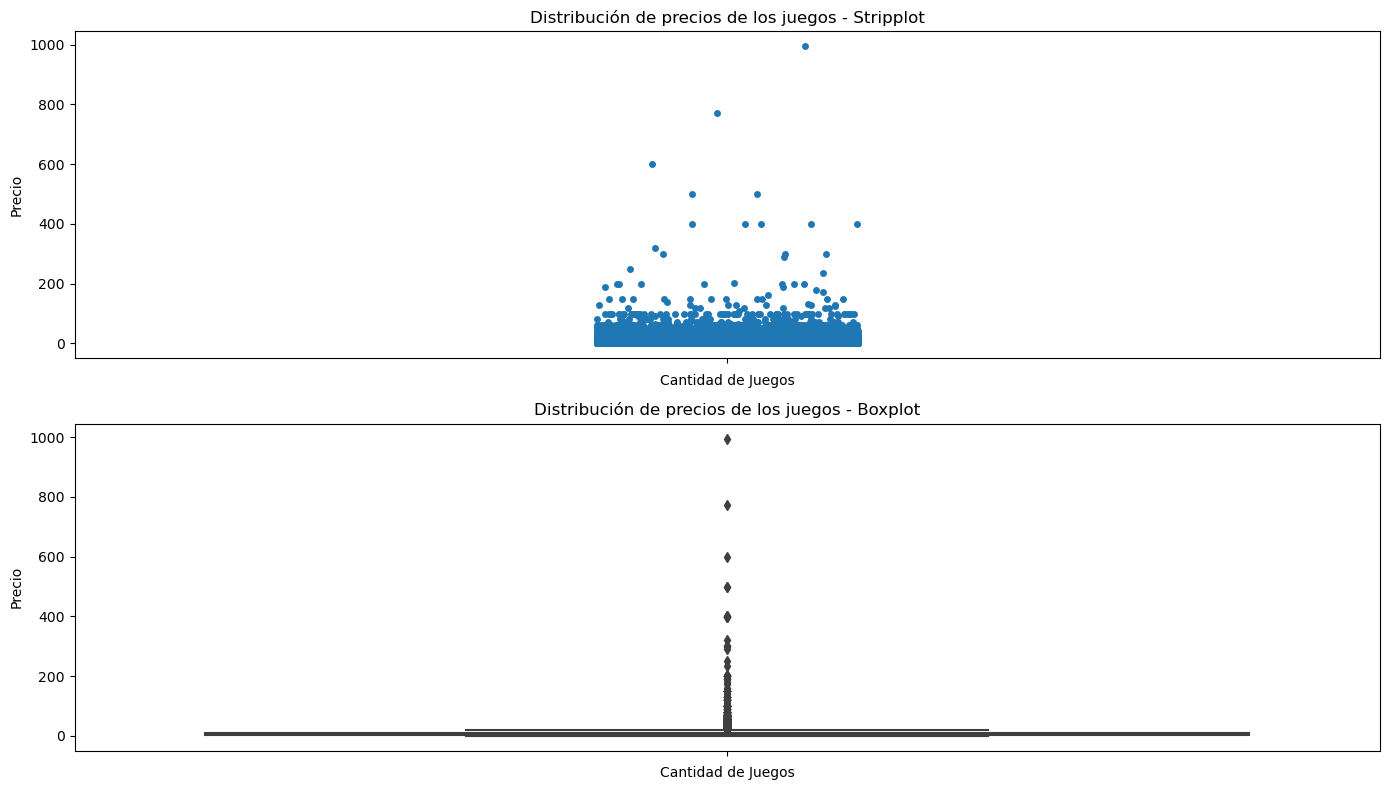

In [20]:
# Obtiene los precios para cada juego y hace un dataframe
precio_unicos = df_games['price'].unique()
df_precio_unicos = df_games['price']
df_precios_uni = pd.DataFrame(df_precio_unicos, columns=['price'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

sns.stripplot(data=df_precios_uni, y='price', ax=ax1)
ax1.set_ylabel('Precio')
ax1.set_xlabel('Cantidad de Juegos')
ax1.set_title('Distribución de precios de los juegos - Stripplot')

sns.boxplot(data=df_precios_uni, y='price', ax=ax2)
ax2.set_ylabel('Precio')
ax2.set_xlabel('Cantidad de Juegos')
ax2.set_title('Distribución de precios de los juegos - Boxplot')

# Muestra y ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()




In [21]:
# Valores estadísticos básicos para stripplot
precio_minimo = df_precios_uni['price'].min()
precio_maximo = df_precios_uni['price'].max()
precio_mediana = df_precios_uni['price'].median()
precio_promedio = df_precios_uni['price'].mean()

print(f"Precio mínimo: {precio_minimo}")
print(f"Precio máximo: {precio_maximo}")
print(f"Mediana de precios: {precio_mediana}")
print(f"Promedio de precios: {precio_promedio}")

Precio mínimo: 0.0
Precio máximo: 995.0
Mediana de precios: 4.99
Promedio de precios: 8.808433563723273


In [22]:
# Valores estadísticos básicos para boxplot
cuartiles = df_precios_uni['price'].quantile([0.25, 0.5, 0.75])
precio_cuartil1 = cuartiles[0.25]
precio_cuartil2 = cuartiles[0.5]
precio_cuartil3 = cuartiles[0.75]
precio_IQR = precio_cuartil3 - precio_cuartil1

print(f"Precio primer cuartil: {precio_cuartil1}")
print(f"Precio segundo cuartil (mediana): {precio_cuartil2}")
print(f"Precio tercer cuartil: {precio_cuartil3}")
print(f"Rango intercuartílico (IQR): {precio_IQR}")

Precio primer cuartil: 2.99
Precio segundo cuartil (mediana): 4.99
Precio tercer cuartil: 9.99
Rango intercuartílico (IQR): 7.0


#### EDA del dataset users_items

*En esta sección se desarrolla el Análisis Exploratorio de los Datos del conjunto users_items que ya pasó por el proceso de ETL.*

*Lectura del conjunto de datos*

###### Se leen los datos de .csv y se guarda en un dataframe.

In [31]:
df_items = pd.read_parquet(r'C:\Users\Owner\Desktop\LABS\Proyecto_STEAM\datos_STEAM\parquet\items_clean.parquet')
df_items.head()

,user_id,items_count,item_id,playtime_forever
0,76561197970982479,277,10,6.0
1,76561197970982479,277,20,0.0
2,76561197970982479,277,30,7.0
3,76561197970982479,277,40,0.0
4,76561197970982479,277,50,0.0


###### Se revisan los tipos de datos y cantidad de nulos si hay.

In [25]:
# Se calcula la cantidad de registros
print(f'La cantidad de registros que hay son: {df_items.shape[0]}')
# Se revisan tipos de datos y existencias de nulos
herramientas.tipo_datos(df_items)

La cantidad de registros que hay son: 32135


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,id,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
1,app_name,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
2,developer,"[<class 'str'>, <class 'NoneType'>]",89.94,10.06,3234
3,genres,"[<class 'str'>, <class 'NoneType'>]",99.57,0.43,139
4,price,[<class 'float'>],96.35,3.65,1173
5,release_date,"[<class 'str'>, <class 'NoneType'>]",93.25,6.75,2168


Columna 'playtime_forever'

###### Estas columnas hacen referencia al tiempo en minutos acumulados que un usuario ha jugado.

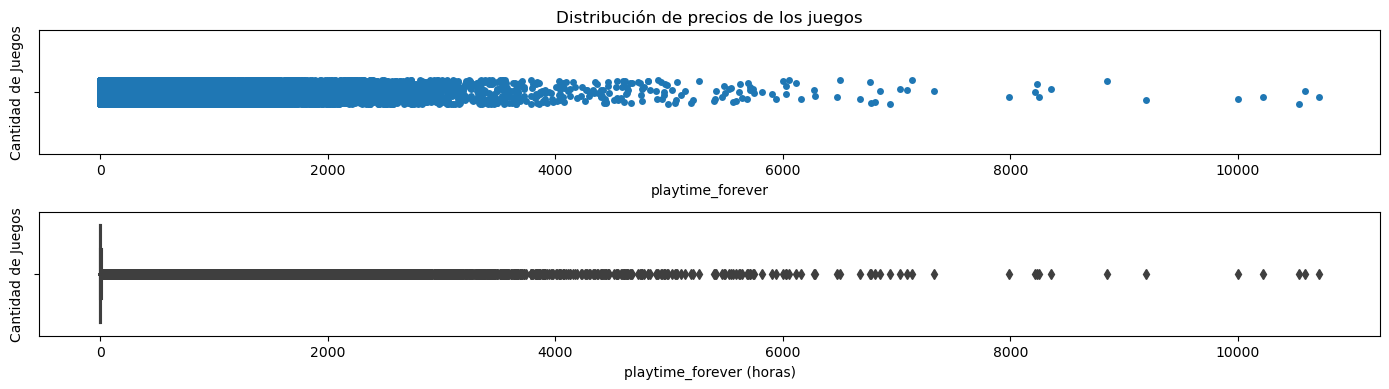

In [32]:
df_items['playtime_hours'] = df_items['playtime_forever'] / 60

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_items, x='playtime_hours', ax=ax1)
ax1.set_xlabel('playtime_forever') ; ax1.set_ylabel('Cantidad de Juegos') ; ax1.set_title('Distribución de precios de los juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_items, x='playtime_hours', ax=ax2)
ax2.set_xlabel('playtime_forever (horas)') ; ax2.set_ylabel('Cantidad de Juegos')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [33]:
# Valores estadísticos básicos para stripplot
playtime_min = df_items['playtime_hours'].min()
playtime_max = df_items['playtime_hours'].max()
playtime_mediana = df_items['playtime_hours'].median()
playtime_promedio = df_items['playtime_hours'].mean()

print(f"Tiempo mínimo de juego (horas): {playtime_min}")
print(f"Tiempo máximo de juego (horas): {playtime_max}")
print(f"Mediana del tiempo de juego (horas): {playtime_mediana}")
print(f"Promedio del tiempo de juego (horas): {playtime_promedio}")

Tiempo mínimo de juego (horas): 0.0
Tiempo máximo de juego (horas): 10712.883333333333
Mediana del tiempo de juego (horas): 0.5666666666666667
Promedio del tiempo de juego (horas): 16.524919013246567


In [34]:
# Valores estadísticos básicos para boxplot
cuartiles_playtime = df_items['playtime_hours'].quantile([0.25, 0.5, 0.75])
playtime_cuartil1 = cuartiles_playtime[0.25]
playtime_cuartil2 = cuartiles_playtime[0.5]
playtime_cuartil3 = cuartiles_playtime[0.75]
playtime_IQR = playtime_cuartil3 - playtime_cuartil1

print(f"Cuartil 1 del tiempo de juego (horas): {playtime_cuartil1}")
print(f"Cuartil 2 del tiempo de juego (horas): {playtime_cuartil2}")
print(f"Cuartil 3 del tiempo de juego (horas): {playtime_cuartil3}")
print(f"Rango intercuartílico (IQR) del tiempo de juego (horas): {playtime_IQR}")

Cuartil 1 del tiempo de juego (horas): 0.0
Cuartil 2 del tiempo de juego (horas): 0.5666666666666667
Cuartil 3 del tiempo de juego (horas): 5.916666666666667
Rango intercuartílico (IQR) del tiempo de juego (horas): 5.916666666666667


Columna 'items_count'

###### Esta columna indica la cantidad de juegos que consumen o compraron alguna vez los usuarios.

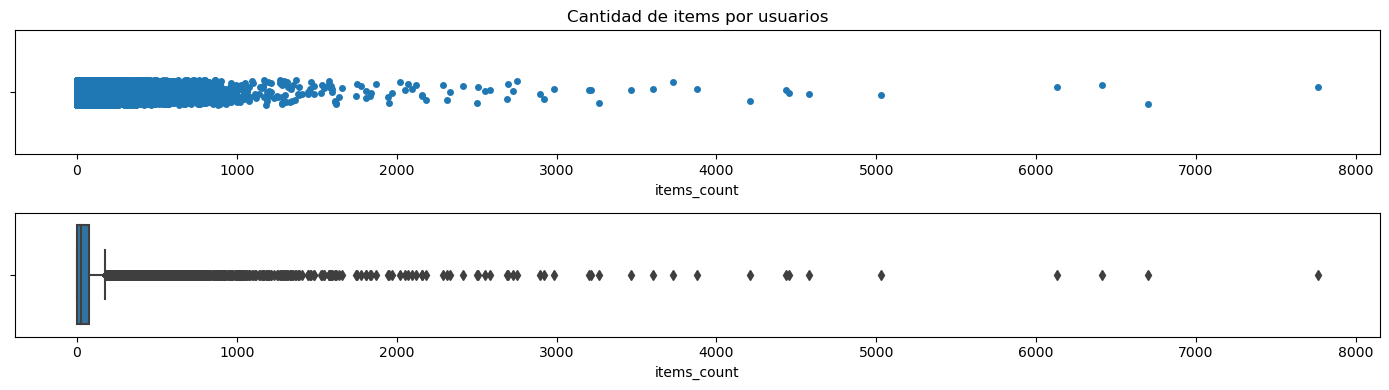

In [35]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
items_count_user = df_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Cantidad de items por usuarios')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [38]:
# Check if the column 'genres' exists in the DataFrame
if 'genres' in df_games.columns:
    print("The column 'genres' exists in the DataFrame.")
else:
    print("The column 'genres' does not exist in the DataFrame.")

# Display the DataFrame's columns
print("\nDataFrame columns:")
print(df_games.columns)

# Display the DataFrame's head to verify its structure
print("\nDataFrame head:")
print(df_games.head())


The column 'genres' does not exist in the DataFrame.

DataFrame columns:
Index(['id', 'app_name', 'developer', 'price', 'release_date', '', '360 Video',
       'Accounting', 'Accounting', 'Adventure', 'Animation & Modeling',
       'Animation &amp; Modeling', 'Anime', 'Arcade', 'Audio Production',
       'Beat 'em up', 'Board Game', 'Cartoon', 'Animation & Modeling', 'Chess',
       'Co-op', 'Comedy', 'Comic Book', 'Controller', 'Design & Illustration',
       'Design &amp; Illustration', 'Documentary', 'Dragons', 'Drama',
       'Early Access', 'Education', 'Episodic', 'FPS', 'Fantasy',
       'Female Protagonist', 'Fighting', 'Football', 'Funny',
       'Game Development', 'Gaming', 'Gore', 'Hacking', 'Hardware',
       'Hidden Object', 'Historical', 'Horror', 'Adventure', 'JRPG', 'MOBA',
       'Martial Arts', 'Massively Multiplayer', 'Memes', 'Metroidvania',
       'Movie', 'Music', 'Ninja', 'Nudity', 'Open World', 'Photo Editing',
       'Platformer', 'Point & Click', 'Politics', 

### Elección de las variables a usar en el modelo de recomendación

In [52]:
# Convertir los valores de los géneros a columnas usando one-hot encoding
genres_dummies = pd.get_dummies(df_games['genres'])

# Concatenar los DataFrames
df_games = pd.concat([df_games, genres_dummies], axis=1)

# Eliminar la columna 'genres' ya que no la necesitamos más
df_games.drop(columns=['genres'], inplace=True)

# Renombrar las columnas de los géneros para que coincidan con el formato deseado
genre_columns = {
    "Action": "Accounting",
    "Indie": "Adventure",
    "Casual": "Animation & Modeling",
    # Añadir aquí los demás géneros...
}
df_games.rename(columns=genre_columns, inplace=True)

# Cambiar True por 1 y False por 0 en todas las columnas del DataFrame
df_games.replace({True: 1, False: 0}, inplace=True)

df_games

,id,app_name,developer,price,release_date,,360 Video,Accounting,Accounting,Adventure,...,Tutorial,Twin Stick Shooter,Utilities,VR,Video Production,Violent,War,Web Publishing,World War II,Zombies
0,761140,Lost Summoner Kitty,Kotoshiro,4.99,2018,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,Ironbound,Secret Level SRL,0.00,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,670290,Real Pool 3D - Poolians,Poolians.com,0.00,2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,弹炸人2222,彼岸领域,0.99,2017,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,Log Challenge,None,2.99,None,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,773640,Colony On Mars,"Nikita ""Ghost_RUS""",1.99,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32131,733530,LOGistICAL: South Africa,Sacada,4.99,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32132,610660,Russian Roads,Laush Dmitriy Sergeevich,1.99,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32133,658870,EXIT 2 - Directions,"xropi,stev3ns",4.99,2017,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
